In [38]:
from cProfile import label
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.image as pmimg
import numpy as np
import nibabel as nib
import skimage.io as io
import skimage.transform as trans
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import tensorflow as tf
import os.path
import cv2 as cv

approot = ""
try:
    approot = os.path.dirname(os.path.abspath(__file__))
except NameError: # We are in a jupyter notebook
    approot = os.getcwd()

# just going to data folder in order to load all dicom
os.chdir(str(approot))
print(str(approot))

c:\Users\abarb\Documents\GitHub\abdomen_segmentation


In [39]:
# Fonctions utiles

# affichage d'image
def fast_display(img2dlst):
    plt.figure(figsize=(32, 12))
    nbImg = len(img2dlst)
    cols = min(6, nbImg)
    rows = (nbImg // cols) + 1
    for jaaj, img2d in enumerate(img2dlst):
        plt.subplot(rows, cols, jaaj + 1)
        plt.imshow(img2d)
    plt.show()

# affichage slice
def print_slices(img):
    disp_list = []
    for i in range(5, min(len(img), 60), 10):
        disp_list.append(img[i])
    fast_display(disp_list)

# calcul des différences entre 2 images (dice)
def compute_dice(X, Y):
    Xbin = (X > 0)
    Ybin = (Y > 0)
    cardIntersec = np.sum(np.logical_and(Xbin, Ybin))
    cardX = np.sum(Xbin)
    cardY = np.sum(Ybin)
    print("cardIntersec = ", cardIntersec)
    print("cardX = ", cardX)
    print("cardY = ", cardY)
    if cardX + cardY > 0:
        dice = (2.0 * cardIntersec)/(cardX + cardY)
        print("dice = ", dice)
        return dice
    else:
        return 0

# normalisation des valeurs dans une image)
def normalize(img):
    m = np.mean(img[img > 0])
    s = np.std(img[img > 0])
    return np.clip((img - m) / (5 * s), -1, 1)

In [40]:
# Fonction de nettoyage des données, suppression des couches non labelisées, réduction de taille, léger découpage et normalisation
raw_data = []
labeled_data = []

def clean_and_save_data(scan, labeled_scan):
    global raw_data
    global labeled_data
    
    for i in range(scan.shape[2]):

        if labeled_scan[:, :, i].sum() == 0:
            continue

        resized_data         = cv.resize(scan[:, :, i], (scan.shape[0]//3, scan.shape[1]//3), cv.INTER_NEAREST)
        resized_data_labeled = cv.resize(labeled_scan[:, :, i], (labeled_scan.shape[0]//3, labeled_scan.shape[1]//3), cv.INTER_NEAREST)

        resized_data         = resized_data[5:resized_data.shape[0]-5, 29:resized_data.shape[1]-29]
        resized_data_labeled = resized_data_labeled[5:resized_data_labeled.shape[0]-5, 29:resized_data_labeled.shape[1]-29]

        resized_data = normalize(resized_data)
        mask_img = np.where(resized_data > -1, 1, 0)
        resized_data_labeled = np.expand_dims(resized_data_labeled, axis=2)
        resized_data = np.expand_dims(resized_data, axis=2)
        mask_img = np.expand_dims(mask_img, axis=2)
        resized_data = np.append(resized_data, mask_img, axis=2)

        raw_data.append(resized_data)
        labeled_data.append(resized_data_labeled)

Data shape  : (2229, 160, 112, 2)
Label shape : (2229, 160, 112, 1)
Raw data type     : <dtype: 'float32'>
Labeled data type : <dtype: 'uint8'>


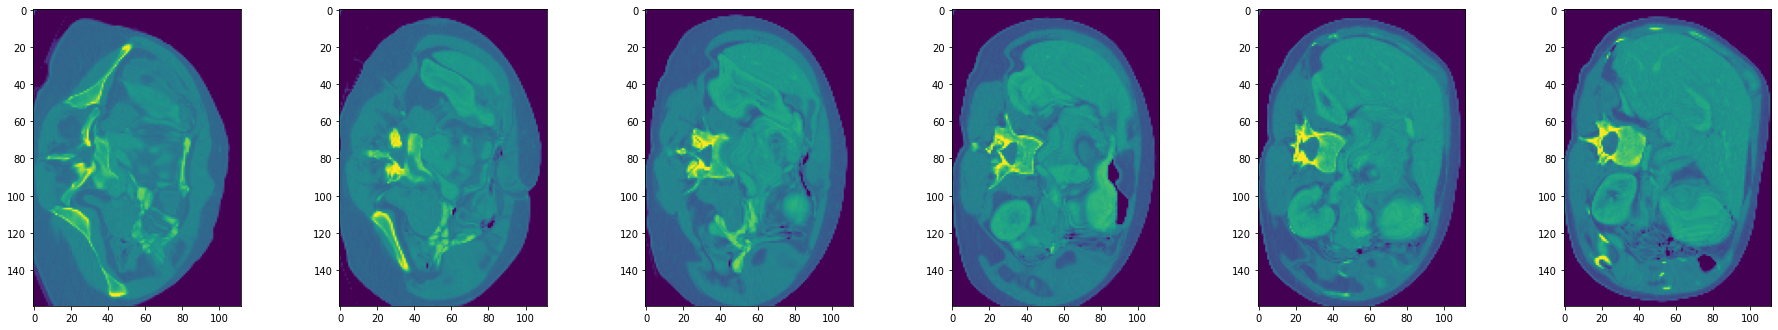

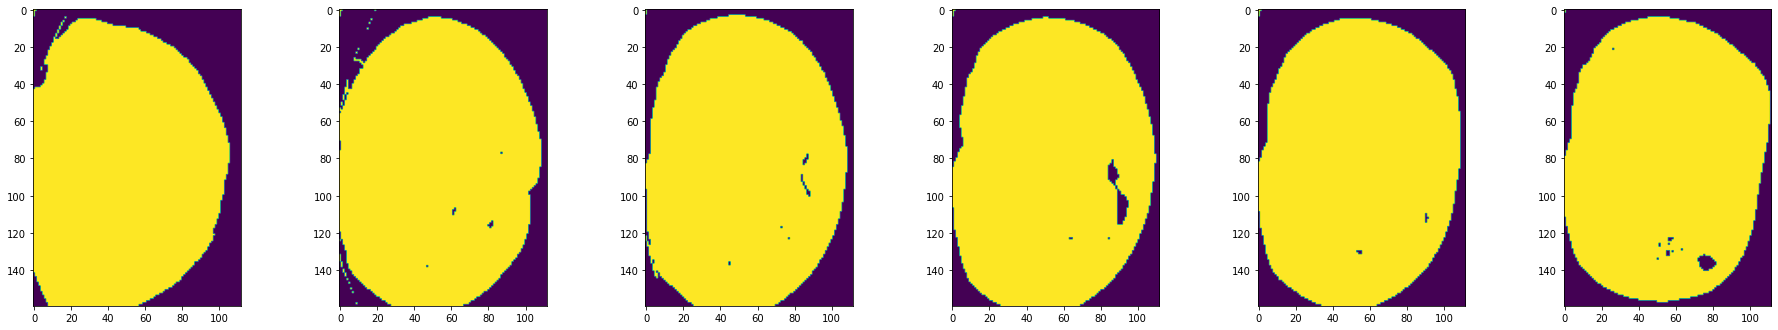

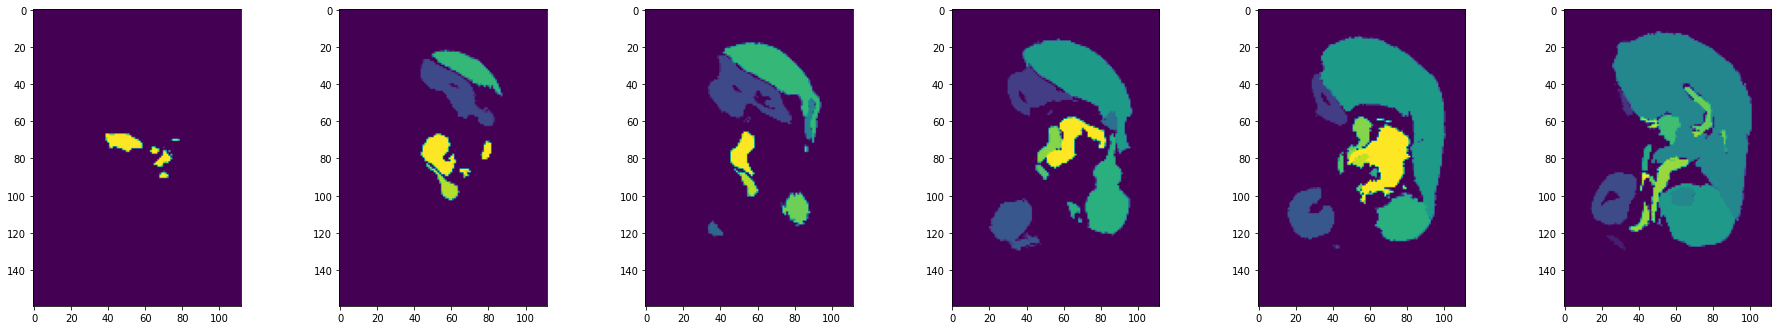

In [41]:
# if true, reload and process data again, else load the data saved previously in files stored in numpy_arrays
RELOAD_DATA = False

if RELOAD_DATA:
    # On a 30 * 30 abdomens + 20 * 30 labelisés au total, on doit les séparer en train, validation, test
    nb_dirs_to_load = 100
    nb_files_to_load_per_dir = 1 # putting a number bigger than the number of files will just loads every file in the folder

    loaded_dirs = 0
    for _, dirs, filenames in os.walk("./data/Training-Training/img"):
        for dir in dirs:

            loaded_dirs += 1
            if loaded_dirs > nb_dirs_to_load:
                break
            
            loaded_files = 0
            for _, dirs2, filenames2 in os.walk("./data/Training-Training/img/" + dir):
                for filename in filenames2:
                    if filename[0] == '.':
                        continue
                    
                    loaded_files += 1
                    if loaded_files > nb_files_to_load_per_dir:
                        break
                    
                    name = "./data/Training-Training/img/" + dir + "/" + filename
                    data = nib.load(name).get_fdata()
                    name_label = "./data/Training-Training/label/" + dir + "/" + "label" + filename[3:]
                    data_label = nib.load(name_label).get_fdata()
                    clean_and_save_data(data, data_label)

    raw_data = np.array(raw_data)
    labeled_data = np.array(labeled_data)
    raw_data = raw_data.astype('float32')
    labeled_data = labeled_data.astype('uint8')
    np.save("numpy_arrays/raw_data.npy", raw_data)
    np.save("numpy_arrays/labeled_data.npy", labeled_data)
else:
    raw_data = np.load("numpy_arrays/raw_data.npy")
    labeled_data = np.load("numpy_arrays/labeled_data.npy")

raw_data = tf.convert_to_tensor(raw_data, np.float32)
labeled_data = tf.convert_to_tensor(labeled_data, np.uint8)

print("Data shape  : " + str(raw_data.shape))
print("Label shape : " + str(labeled_data.shape))
print('Raw data type     :', raw_data.dtype)
print('Labeled data type :', labeled_data.dtype)
print_slices(raw_data[:, :, :, 0])
print_slices(raw_data[:, :, :, 1])
print_slices(labeled_data)

In [42]:
# ---- UNET classique ----

_, sx, sy, sz = raw_data.shape

nbf64 = 8
nbf128 = 2 * nbf64
nbf256 = 2 * nbf128
nbf512 = 2 * nbf256
nbf1024 = 2 * nbf512

def unet(input_size = (sx, sy, 2)):
    inputs = Input(input_size)
    conv1 = Conv2D(nbf64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(inputs)
    conv1 = Conv2D(nbf64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    conv2 = Conv2D(nbf128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool1)
    conv2 = Conv2D(nbf128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
    conv3 = Conv2D(nbf256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool2)
    conv3 = Conv2D(nbf256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
    conv4 = Conv2D(nbf512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool3)
    conv4 = Conv2D(nbf512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

    conv5 = Conv2D(nbf1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool4)
    conv5 = Conv2D(nbf1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
    model.summary()

    return model

model = unet(input_size = (sx, sy, 2))

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 160, 112, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_96 (Conv2D)             (None, 160, 112, 8)  152         ['input_5[0][0]']                
                                                                                                  
 conv2d_97 (Conv2D)             (None, 160, 112, 8)  584         ['conv2d_96[0][0]']              
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 80, 56, 8)   0           ['conv2d_97[0][0]']        

xtrain shape      : (1783, 160, 112, 2)
ytrain shape      : (1783, 160, 112, 1)
xvalidation shape : (223, 160, 112, 2)
yvalidation shape : (223, 160, 112, 1)
xtest shape       : (223, 160, 112, 2)
ytest shape       : (223, 160, 112, 1)


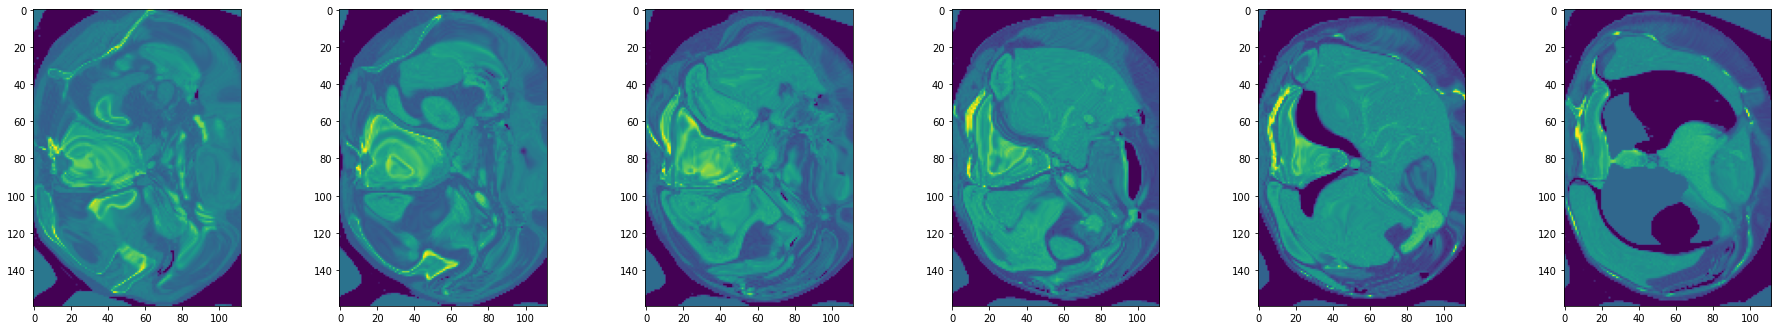

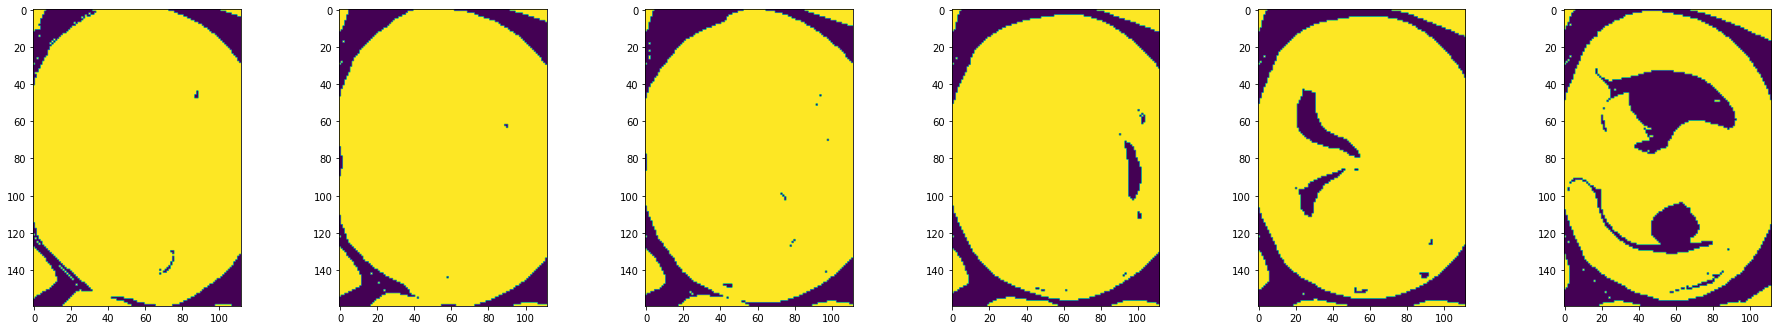

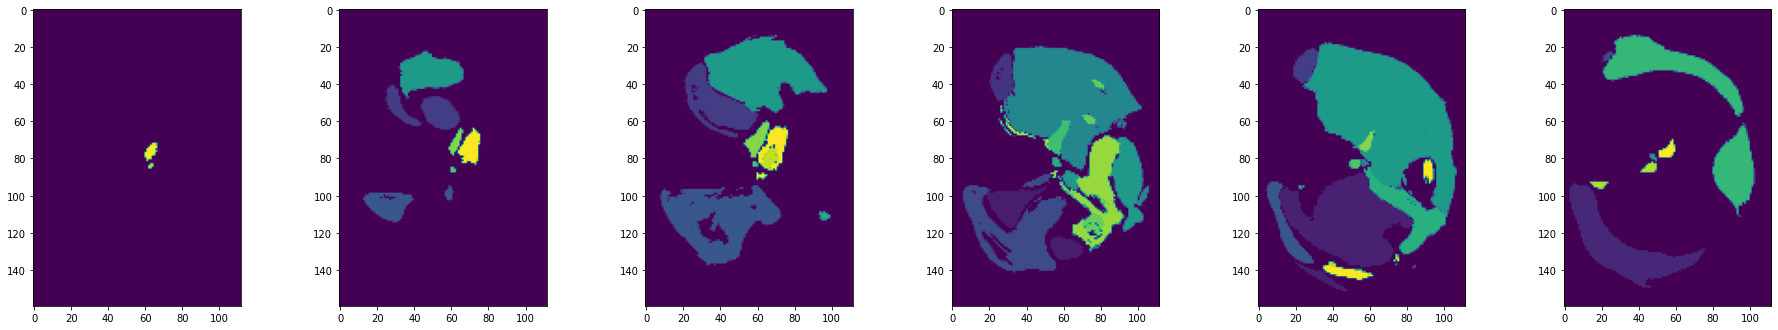

In [43]:
x, y = (0.8, 0.1) # split with x = 80%, y = 10% and therefore z = 10%
lenx = int(len(raw_data)*x)
leny = int(len(raw_data)*(x+y))

xtrain, xvalidation, xtest = np.split(raw_data, [lenx, leny])
ytrain, yvalidation, ytest = np.split(labeled_data, [lenx, leny])

print("xtrain shape      : " + str(xtrain.shape))
print("ytrain shape      : " + str(ytrain.shape))
print("xvalidation shape : " + str(xvalidation.shape))
print("yvalidation shape : " + str(yvalidation.shape))
print("xtest shape       : " + str(xtest.shape))
print("ytest shape       : " + str(ytest.shape))


print_slices(xtest[:, :, :, 0])
print_slices(xtest[:, :, :, 1])
print_slices(ytest)

In [44]:
# ---- entrainement ----

DO_WE_LEARN = True
epochs = 1
if DO_WE_LEARN:
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=2, mode='auto', baseline=None, restore_best_weights=True)

    history = model.fit(
    verbose = 1,
    initial_epoch = 0,
    x = xtrain,
    y = ytrain,
    batch_size = 32,
    validation_data = (xvalidation, yvalidation),
    epochs = epochs,
    callbacks = [early_stopping]
    )
    model.save_weights("model.hdf5")
else:
    model.load_weights("model.hdf5")

56/56 [==============================] - 15s 252ms/step - loss: nan - accuracy: 0.8469 - val_loss: nan - val_accuracy: 0.8573


In [45]:
prediction = np.round(model.predict(xtest, verbose = 0))

(223, 160, 112, 1)
[nan]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


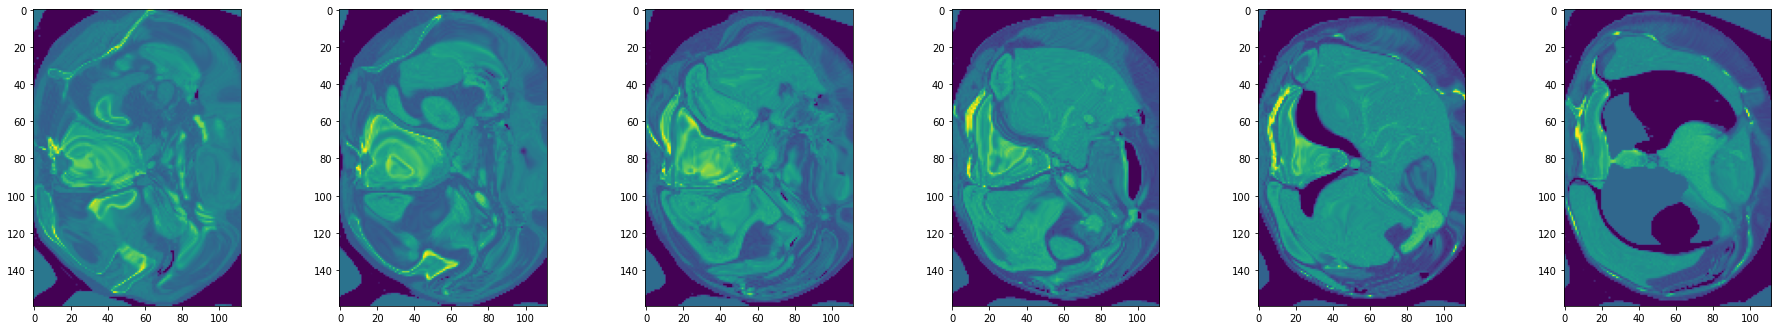

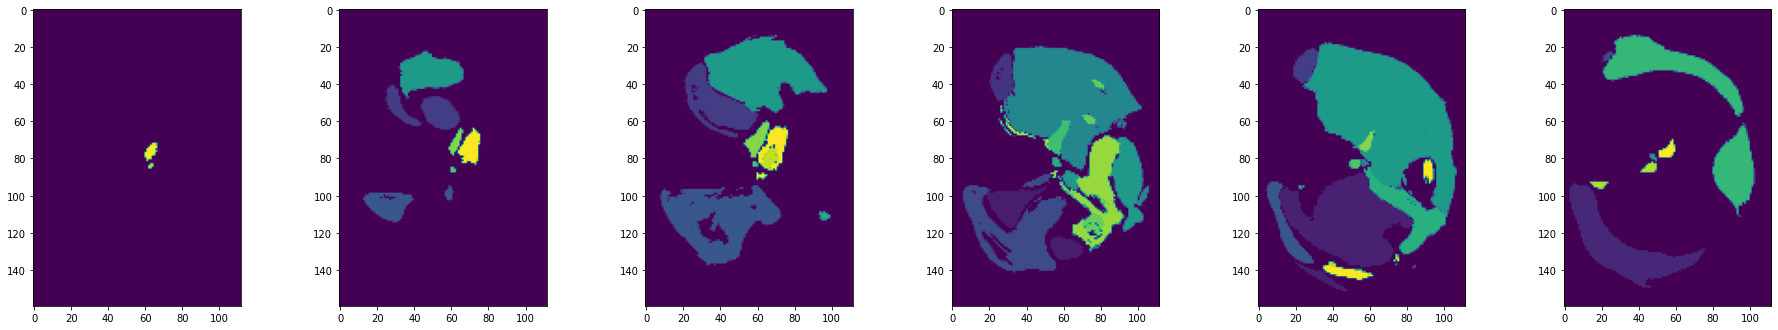

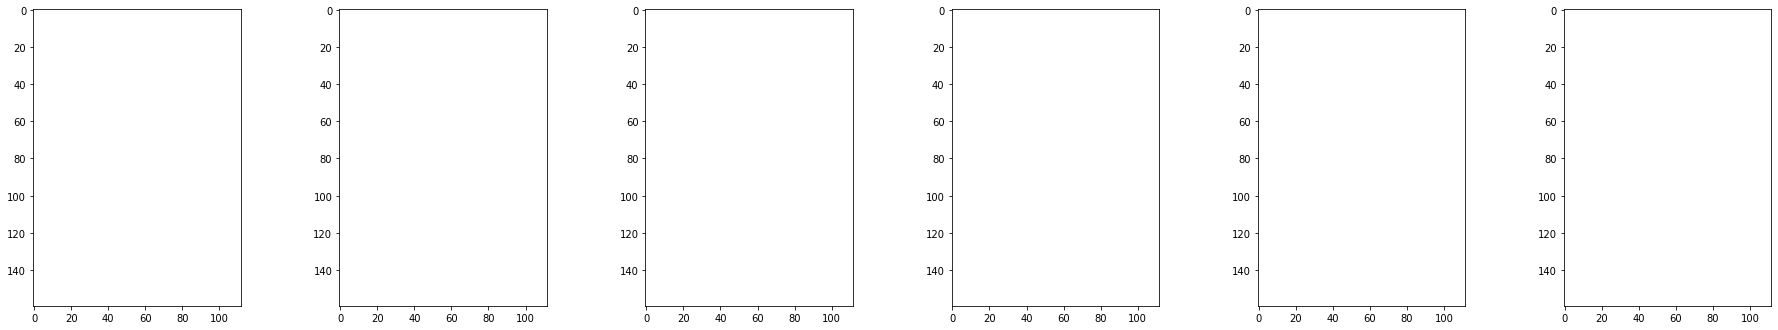

In [46]:
# print(compute_dice(xtest, ytest)) # pb ici
print(prediction.shape)
print(np.unique(prediction))
print(np.unique(ytest))
print_slices(xtest[:, :, :, 0])
print_slices(ytest)
print_slices(prediction)